Linear Regression (Scaled) Results:
MAE: 6,781,719.49
RMSE: 13,948,841.41
R²: 0.7376 | Adjusted R²: 0.6976
---
Random Forest (Tuned) Results:
MAE: 5,461,627.99
RMSE: 12,485,249.28
R²: 0.7898 | Adjusted R²: 0.7577
---

Top 10 Important Features:
Log_Area                     0.316464
Area_BHK                     0.237887
Bathroom                     0.160113
BHK                          0.133127
Parking                      0.041290
Transaction_Resale           0.014156
Neighborhood_Lajpat Nagar    0.011959
Type_Builder_Floor           0.011517
Neighborhood_Mehrauli        0.009295
Neighborhood_Other           0.006670
dtype: float64


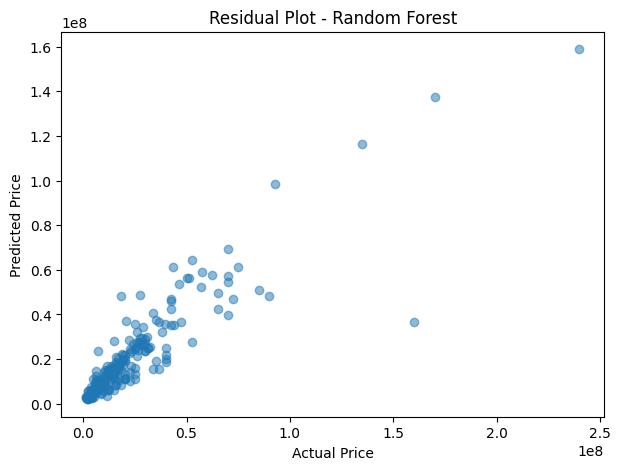


Sample Random Forest Prediction: 2955094
Actual Price: 3200000

Best Parameters Found: {'bootstrap': False, 'max_depth': 20, 'max_features': 'sqrt', 'min_samples_leaf': 1, 'min_samples_split': 5, 'n_estimators': 100}


In [1]:
import pandas as pd
import numpy as np
import re
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score

# Load Data
df = pd.read_csv('/kaggle/input/houseprice/MagicBricks.csv')

# Fill Missing Values
df['Bathroom'] = df['Bathroom'].fillna(df['Bathroom'].median())
df['Parking'] = df['Parking'].fillna(0)
df['Furnishing'] = df['Furnishing'].fillna('Unknown')
df['Type'] = df['Type'].fillna('Unknown')

# Drop rows where Price or Area missing
df = df.dropna(subset=['Price', 'Area'])

# Remove Outliers (IQR method on Price per Sqft but computed safely)
df['Per_Sqft_temp'] = df['Price'] / df['Area']
Q1, Q3 = df['Per_Sqft_temp'].quantile([0.25, 0.75])
IQR = Q3 - Q1
lower, upper = Q1 - 1.5 * IQR, Q3 + 1.5 * IQR
df = df[(df['Per_Sqft_temp'] >= lower) & (df['Per_Sqft_temp'] <= upper)]
df = df[(df['Area'] >= 200) & (df['Price'] >= 300000)]
df.drop(columns=['Per_Sqft_temp'], inplace=True)

# Log transforms to handle skewness
df['Log_Price'] = np.log(df['Price'] + 1)
df['Log_Area'] = np.log(df['Area'] + 1)

# Extract Neighborhood more robustly
df['Neighborhood'] = df['Locality'].str.extract(r'([A-Za-z ]+)', expand=False).fillna('Other')
df['Neighborhood'] = df['Neighborhood'].str.strip().str.title()
top_neighborhoods = df['Neighborhood'].value_counts().nlargest(20).index
df['Neighborhood'] = df['Neighborhood'].apply(lambda x: x if x in top_neighborhoods else 'Other')

# Interaction term: Area * BHK
df['Area_BHK'] = df['Area'] * df['BHK']

# Encode categorical variables
df = pd.get_dummies(df, columns=['Furnishing', 'Status', 'Transaction', 'Type', 'Neighborhood'], drop_first=True)

features = (['Log_Area', 'BHK', 'Bathroom', 'Parking', 'Area_BHK'] +
            [col for col in df.columns if col.startswith('Furnishing_') or
                                           col.startswith('Status_') or
                                           col.startswith('Transaction_') or
                                           col.startswith('Type_') or
                                           col.startswith('Neighborhood_')])

X = df[features]
Y = df['Log_Price']

X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=0.2, random_state=42)

# Standardize for Linear Regression
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# Linear Regression
lr = LinearRegression()
lr.fit(X_train_scaled, Y_train)
y_pred_lr = lr.predict(X_test_scaled)

# Random Forest with better tuning
param_grid = {
    'n_estimators': [100, 200, 300],
    'max_depth': [None, 10, 20],
    'min_samples_split': [2, 5],
    'min_samples_leaf': [1, 2],
    'max_features': ['sqrt', 'log2'],
    'bootstrap': [True, False]
}

rf = RandomForestRegressor(random_state=42)
grid_search = GridSearchCV(estimator=rf, param_grid=param_grid,
                           cv=5, n_jobs=-1, scoring='neg_mean_squared_error')

grid_search.fit(X_train, Y_train)
best_rf = grid_search.best_estimator_
y_pred_rf = best_rf.predict(X_test)

def evaluate(y_true, preds, label):
    y_true_orig = np.exp(y_true) - 1
    preds_orig = np.exp(preds) - 1
    mae = mean_absolute_error(y_true_orig, preds_orig)
    rmse = np.sqrt(mean_squared_error(y_true_orig, preds_orig))
    r2 = r2_score(y_true_orig, preds_orig)
    adj_r2 = 1 - (1 - r2) * (len(y_true) - 1) / (len(y_true) - X_test.shape[1] - 1)

    print(f'{label} Results:')
    print(f'MAE: {mae:,.2f}')
    print(f'RMSE: {rmse:,.2f}')
    print(f'R²: {r2:.4f} | Adjusted R²: {adj_r2:.4f}')
    print('---')

evaluate(Y_test, y_pred_lr, 'Linear Regression (Scaled)')
evaluate(Y_test, y_pred_rf, 'Random Forest (Tuned)')

importances = pd.Series(best_rf.feature_importances_, index=X.columns).sort_values(ascending=False)
print("\nTop 10 Important Features:")
print(importances.head(10))

plt.figure(figsize=(7,5))
plt.scatter(np.exp(Y_test)-1, np.exp(y_pred_rf)-1, alpha=0.5)
plt.xlabel("Actual Price")
plt.ylabel("Predicted Price")
plt.title("Residual Plot - Random Forest")
plt.show()

sample_pred = np.exp(best_rf.predict(X_test.iloc[[0]]))[0] - 1
actual_val = np.exp(Y_test.iloc[0]) - 1

print("\nSample Random Forest Prediction:", round(sample_pred))
print("Actual Price:", round(actual_val))

print("\nBest Parameters Found:", grid_search.best_params_)
